In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import ast

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

plt.style.use('ggplot')
%matplotlib inline

In [3]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 100)

In [4]:
link = 's3a://helen.assignment/master.csv'

In [5]:
df = pd.read_csv(link)

In [6]:
df.head()

,backers_count,blurb,category,converted_pledged_amount,country,country_displayable_name,created_at,creator,currency,currency_symbol,currency_trailing_code,current_currency,deadline,disable_communication,friends,fx_rate,goal,id,is_backing,is_starrable,is_starred,launched_at,location,name,permissions,photo,pledged,profile,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type
0,5,A Free to Win Online Mobile Strategy Game to end the corruption of the rich players always winni...,"{""id"":272,""name"":""Mobile Games"",""slug"":""games/mobile games"",""position"":3,""parent_id"":12,""parent_...",83,CA,Canada,1506125024,"{""id"":1178629187,""name"":""Adam Tompkins"",""is_registered"":null,""chosen_currency"":null,""is_superbac...",CAD,$,True,USD,1507560063,False,NaN,0.70837,1000.0,751419376,NaN,False,NaN,1506350463,"{""id"":22664159,""name"":""Mississauga"",""slug"":""mississauga-ca"",""short_name"":""Mississauga, Canada"",""...",Iron Age Kingdoms - First Free To Win Mobile Strategy Game,NaN,"{""key"":""assets/018/444/378/81e59ccab10259506aab6ee340d25b73_original.png"",""full"":""https://ksr-ug...",105.0,"{""id"":3151330,""project_id"":3151330,""state"":""inactive"",""state_changed_at"":1506125024,""name"":null,...",iron-age-kingdoms-first-free-to-win-mobile-strateg,https://www.kickstarter.com/discover/categories/games/mobile%20games,False,False,failed,1507560063,0.810764,"{""web"":{""project"":""https://www.kickstarter.com/projects/1178629187/iron-age-kingdoms-first-free-...",85.130189,domestic
1,19,"Lizard is a dark comedy and modern western, that takes place in the Mojave Desert.","{""id"":11,""name"":""Film & Video"",""slug"":""film & video"",""position"":7,""color"":16734574,""urls"":{""web""...",2358,US,the United States,1561667598,"{""id"":1624125450,""name"":""Darrin Williams"",""slug"":""lizardshortfilm"",""is_registered"":null,""chosen_...",USD,$,True,USD,1569109188,False,NaN,1.00000,1100.0,289952460,NaN,False,NaN,1563925188,"{""id"":2452741,""name"":""Mojave"",""slug"":""mojave-ca"",""short_name"":""Mojave, CA"",""displayable_name"":""M...","""Lizard"" a short film",NaN,"{""key"":""assets/025/890/832/ff7ffe91d4b15641a58cb7787182e070_original.jpg"",""full"":""https://ksr-ug...",2358.0,"{""id"":3762384,""project_id"":3762384,""state"":""active"",""state_changed_at"":1569117788,""name"":""""Lizar...",lizard-a-short-film,https://www.kickstarter.com/discover/categories/film%20&%20video,True,False,successful,1569109188,1.000000,"{""web"":{""project"":""https://www.kickstarter.com/projects/lizardshortfilm/lizard-a-short-film?ref=...",2358.000000,domestic
2,5,My friend and I are making an app that has never been made before. Making a football turn based ...,"{""id"":272,""name"":""Mobile Games"",""slug"":""games/mobile games"",""position"":3,""parent_id"":12,""parent_...",172,US,the United States,1453500203,"{""id"":1843687675,""name"":""Mike Teorsky"",""is_registered"":null,""chosen_currency"":null,""is_superback...",USD,$,True,USD,1458681077,False,NaN,1.00000,25000.0,37585826,NaN,False,NaN,1453500677,"{""id"":2473224,""name"":""Pittsburgh"",""slug"":""pittsburgh-pa"",""short_name"":""Pittsburgh, PA"",""displaya...",Total Franchise Football 2016,NaN,"{""key"":""assets/012/361/145/208a4baab227d49c5d23f46a8361cd9c_original.jpg"",""full"":""https://ksr-ug...",172.0,"{""id"":2335556,""project_id"":2335556,""state"":""inactive"",""state_changed_at"":1453500203,""name"":null,...",total-franchise-football-2016,https://www.kickstarter.com/discover/categories/games/mobile%20games,False,False,failed,1458681110,1.000000,"{""web"":{""project"":""https://www.kickstarter.com/projects/1843687675/total-franchise-football-2016...",172.000000,domestic
3,23,"More than a bike trip, a state of mind. And a book.","{""id"":48,""name"":""Nonfiction"",""slug"":""publishing/nonfiction"",""position"":9,""parent_id"":18,""parent_...",501,US,the United States,1345516420,"{""id"":376746530,""name"":""John Farley

In [7]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204625 entries, 0 to 204624
Data columns (total 38 columns):
backers_count               204625 non-null int64
blurb                       204618 non-null object
category                    204625 non-null object
converted_pledged_amount    204625 non-null int64
country                     204625 non-null object
country_displayable_name    204625 non-null object
created_at                  204625 non-null int64
creator                     204625 non-null object
currency                    204625 non-null object
currency_symbol             204625 non-null object
currency_trailing_code      204625 non-null bool
current_currency            204625 non-null object
deadline                    204625 non-null int64
disable_communication       204625 non-null bool
friends                     156 non-null object
fx_rate                     204625 non-null float64
goal                        204625 non-null float64
id                          204

(204625, 38)

## Data Cleaning

In [8]:
cols_to_convert = ['created_at', 'state_changed_at', 'deadline', 'launched_at']
for c in cols_to_convert:
    df[c] = pd.to_datetime(df[c], origin='unix', unit='s')

In [9]:
print(df['friends'].unique())
print(df['is_backing'].unique())
print(df['is_starred'].unique())
print(df['permissions'].unique())
print(df['currency_symbol'].unique())
print(df['currency_trailing_code'].unique())
print(df['current_currency'].unique())
print(df['currency'].unique())
print(df['usd_type'].unique())


[nan '[]']
[nan False]
[nan False True]
[nan '[]']
['$' '€' '¥' '£' 'kr' 'Fr ']
[ True False]
['USD' 'EUR' 'CAD']
['CAD' 'USD' 'EUR' 'JPY' 'AUD' 'GBP' 'SGD' 'DKK' 'NOK' 'MXN' 'HKD' 'SEK'
 'NZD' 'CHF']
['domestic' nan]


In [10]:
df[df['id'] == 1875733470]

,backers_count,blurb,category,converted_pledged_amount,country,country_displayable_name,created_at,creator,currency,currency_symbol,currency_trailing_code,current_currency,deadline,disable_communication,friends,fx_rate,goal,id,is_backing,is_starrable,is_starred,launched_at,location,name,permissions,photo,pledged,profile,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type
27934,128,Help us take our hand-dyed farm yarns on the road in a custom trailer complete with a dye statio...,"{""id"":348,""name"":""Knitting"",""slug"":""crafts/knitting"",""position"":6,""parent_id"":26,""parent_name"":""...",8995,US,the United States,2016-06-02 23:45:41,"{""id"":2004942297,""name"":""Kelly L. Corbett"",""slug"":""romneyridge"",""is_registered"":null,""chosen_cur...",USD,$,True,USD,2016-07-13 16:32:43,False,NaN,1.0,8000.0,1875733470,NaN,False,NaN,2016-06-13 16:32:43,"{""id"":2523917,""name"":""Woolwich"",""slug"":""woolwich-me"",""short_name"":""Woolwich, ME"",""displayable_na...",Romney Ridge Yarns & Wool Pop-Up Shop!,NaN,"{""key"":""assets/012/618/886/97cc3d7948615efb7b5c5941c00d0aff_original.JPG"",""full"":""https://ksr-ug...",8995.0,"{""id"":2543599,""project_id"":2543599,""state"":""active"",""state_changed_at"":1468592118,""name"":""Romney...",romney-ridge-yarns-and-wool-pop-up-shop,https://www.kickstarter.com/discover/categories/crafts/knitting,True,False,successful,2016-07-13 16:32:43,1.0,"{""web"":{""project"":""https://www.kickstarter.com/projects/romneyridge/romney-ridge-yarns-and-wool-...",8995.0,domestic
190116,128,Help us take our hand-dyed farm yarns on the road in a custom trailer complete with a dye statio...,"{""id"":348,""name"":""Knitting"",""slug"":""crafts/knitting"",""position"":6,""parent_id"":26,""parent_name"":""...",8995,US,the United States,2016-06-02 23:45:41,"{""id"":2004942297,""name"":""Kelly L. Corbett"",""slug"":""romneyridge"",""is_registered"":null,""chosen_cur...",USD,$,True,USD,2016-07-13 16:32:43,False,NaN,1.0,8000.0,1875733470,NaN,False,NaN,2016-06-13 16:32:43,"{""id"":2523917,""name"":""Woolwich"",""slug"":""woolwich-me"",""short_name"":""Woolwich, ME"",""displayable_na...",Romney Ridge Yarns & Wool Pop-Up Shop!,NaN,"{""key"":""assets/012/618/886/97cc3d7948615efb7b5c5941c00d0aff_original.JPG"",""full"":""https://ksr-ug...",8995.0,"{""id"":2543599,""project_id"":2543599,""state"":""active"",""state_changed_at"":1468592118,""name"":""Romney...",romney-ridge-yarns-and-wool-pop-up-shop,https://www.kickstarter.com/discover/categories/crafts,True,False,successful,2016-07-13 16:32:43,1.0,"{""web"":{""project"":""https://www.kickstarter.com/projects/romneyridge/romney-ridge-yarns-and-wool-...",8995.0,domestic


In [11]:
df['id'].value_counts()

1875733470    2
1870820362    2
1103759530    2
1796481859    2
1693070447    2
2073431474    2
380634021     2
1222692931    2
85610935      2
1698865203    2
1371189772    2
2095482074    2
839640273     2
1504865726    2
1688389979    2
1508364609    2
1210598165    2
1969606090    2
374214362     2
387871138     2
725743053     2
1551307893    2
432804033     2
1292834024    2
1591277837    2
1054889088    2
271105152     2
1788178973    2
805305740     2
1945003647    2
             ..
1747087057    1
2076639538    1
1202424099    1
270355555     1
1605343521    1
1592137058    1
1266005476    1
1293842717    1
551973148     1
136685040     1
1387202867    1
1124923725    1
1966070172    1
386462028     1
1121503563    1
490725961     1
1279915058    1
1022140742    1
1230289221    1
72555850      1
1015845184    1
1252995380    1
1806395711    1
350177595     1
200229178     1
2124896569    1
300896568     1
977921072     1
2013477173    1
1329596417    1
Name: id, Length: 180753

In [12]:
#remove all duplicate rows
df.drop_duplicates(subset='id', keep='first', inplace=True)
df.shape

(180753, 38)

In [13]:
df[df['id'] == 1103759530]

,backers_count,blurb,category,converted_pledged_amount,country,country_displayable_name,created_at,creator,currency,currency_symbol,currency_trailing_code,current_currency,deadline,disable_communication,friends,fx_rate,goal,id,is_backing,is_starrable,is_starred,launched_at,location,name,permissions,photo,pledged,profile,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type
122464,100,"New folk music & song show by Derby trio Moirai. A 100 year old tale of fake news, family values...","{""id"":37,""name"":""Country & Folk"",""slug"":""music/country & folk"",""position"":5,""parent_id"":14,""pare...",3852,GB,the United Kingdom,2019-08-28 09:55:39,"{""id"":612927420,""name"":""Moirai"",""slug"":""alicewheeldonstory"",""is_registered"":null,""chosen_currenc...",GBP,£,False,USD,2019-10-16 17:00:11,False,NaN,1.24678,2500.0,1103759530,NaN,False,NaN,2019-09-16 17:00:11,"{""id"":18114,""name"":""Derby"",""slug"":""derby-gb"",""short_name"":""Derby, UK"",""displayable_name"":""Derby,...",Framed: The Alice Wheeldon Story - help us spread the word!,NaN,"{""key"":""assets/026/358/508/1b804b34c2c5dbe3174260f0c019bbb1_original.png"",""full"":""https://ksr-ug...",3021.0,"{""id"":3802244,""project_id"":3802244,""state"":""inactive"",""state_changed_at"":1566986139,""name"":null,...",framed-the-alice-wheeldon-story-help-us-spread-the-word,https://www.kickstarter.com/discover/categories/music/country%20&%20folk,True,False,successful,2019-10-16 17:00:11,1.250602,"{""web"":{""project"":""https://www.kickstarter.com/projects/alicewheeldonstory/framed-the-alice-whee...",3778.068189,domestic


In [14]:
df['state'].value_counts()

successful    97906
failed        71720
canceled       8593
live           2534
Name: state, dtype: int64

Text(0, 0.5, 'Count')

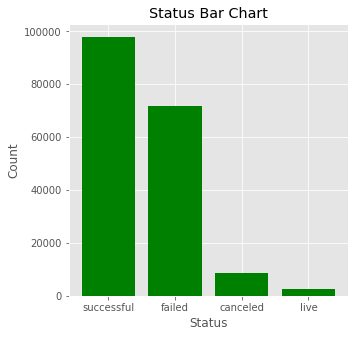

In [15]:
fig, ax = plt.subplots(figsize=(5,5))

x = df['state'].value_counts()
ax.bar(x.index, height=x.values, width=0.8, color='green')
ax.set_title('Status Bar Chart')
ax.set_xlabel("Status")
ax.set_ylabel("Count")

In [16]:
#spotlight column is data leakage. Needs removal 
df[['state', 'spotlight']].groupby('spotlight').count()

,state
spotlight,
False,82847
True,97906


In [17]:
df[['state', 'staff_pick']].groupby('staff_pick').count()

,state
staff_pick,
False,157840
True,22913


In [18]:
# remove entries that are cancelled
df1 = df[df['state'].isin(['successful', 'failed', 'live'])]
df1.shape

(172160, 38)

In [19]:
cols_to_remove = ['friends', 'is_backing', 'is_starred', 'permissions', 
                   'currency_symbol', 'currency_trailing_code', 'spotlight',
                  'current_currency', 'currency','usd_type', 'source_url',
                  'country', 'disable_communication', 'fx_rate', 'photo',
                  'static_usd_rate', 'urls', 'created_at', 'is_starrable',
                 'location', 'profile', 'creator', 'id',
                 'usd_pledged', 'converted_pledged_amount', 'state_changed_at']
df2 = df1.drop(cols_to_remove, axis=1)
df2

,backers_count,blurb,category,country_displayable_name,deadline,goal,launched_at,name,pledged,slug,staff_pick,state
0,5,A Free to Win Online Mobile Strategy Game to end the corruption of the rich players always winni...,"{""id"":272,""name"":""Mobile Games"",""slug"":""games/mobile games"",""position"":3,""parent_id"":12,""parent_...",Canada,2017-10-09 14:41:03,1000.0,2017-09-25 14:41:03,Iron Age Kingdoms - First Free To Win Mobile Strategy Game,105.00,iron-age-kingdoms-first-free-to-win-mobile-strateg,False,failed
1,19,"Lizard is a dark comedy and modern western, that takes place in the Mojave Desert.","{""id"":11,""name"":""Film & Video"",""slug"":""film & video"",""position"":7,""color"":16734574,""urls"":{""web""...",the United States,2019-09-21 23:39:48,1100.0,2019-07-23 23:39:48,"""Lizard"" a short film",2358.00,lizard-a-short-film,False,successful
2,5,My friend and I are making an app that has never been made before. Making a football turn based ...,"{""id"":272,""name"":""Mobile Games"",""slug"":""games/mobile games"",""position"":3,""parent_id"":12,""parent_...",the United States,2016-03-22 21:11:17,25000.0,2016-01-22 22:11:17,Total Franchise Football 2016,172.00,total-franchise-football-2016,False,failed
3,23,"More than a bike trip, a state of mind. And a book.","{""id"":48,""name"":""Nonfiction"",""slug"":""publishing/nonfiction"",""position"":9,""parent_id"":18,""parent_...",the United States,2012-09-25 02:33:06,500.0,2012-09-15 02:33:06,The Trans-American Psychogeographic Literary Cycle Tour,501.00,the-trans-american-psychogeographic-literary-cycle,False,successful
4,0,This is the birth of a revolutionary artist...Revery! A burst out into the world with GAME CHANG...,"{""id"":39,""name"":""Hip-Hop"",""slug"":""music/hip-hop"",""position"":8,""parent_id"":14,""parent_name"":""Musi...",the United States,2017-12-11 02:43:11,2500.0,2017-11-10 02:43:11,The Golden Ticket to the Wonka Factory,0.00,the-golden-ticket-to-the-wonka-factory,False,failed
5,182,A digital archive of New Orleans hiphop and bounce supported by the Amistad Research Center laun...,"{""id"":39,""name"":""Hip-Hop"",""slug"":""music/hip-hop"",""position"":8,""parent_id"":14,""parent_name"":""Musi...",the United States,2013-12-22 20:36:09,6000.0,2013-12-02 20:36:09,NOLA Hiphop Archive,6173.05,nola-hiphop-archive,True,successful
6,114,"For one night only, TOKYOtheCOMPANY performs live on stage in a performance choreographed by TOKYO!","{""id"":254,""name"":""Performances"",""slug"":""dance/performances"",""position"":1,""parent_id"":6,""parent_n...",the United States,2014-09-04 03:59:00,20000.0,2014-08-13 23:45:22,TOKYOtheCOMPANY Presents: Where It Began,20552.00,tokyothecompany-presents-where-it-began,True,successful
7,14,"What do you get when you mix members of Cypress Hill, Tha Alkaholiks, Beatnuts, MOP and Funkdoob...","{""id"":39,""name"":""Hip-Hop"",""slug"":""music/hip-hop"",""position"":8,""parent_id"":14,""parent_name"":""Musi...",the United States,2014-08-26 00:19:16,3000.0,2014-07-29 00:19:16,"Sen Dog of Cypress Hill presents ""HIP HOP"" by Big Herc",3260.00,sen-dog-of-cypress-hill-presents-hip-hop-by-big-he,True,successful
8,31,Seattle dance company celebrates six years with a fantastic final performance.,"{""id"":254,""name"":""Performances"",""slug"":""dance/performances"",""position"":1,""parent_id"":6,""parent_n...",the United States,2018-02-16 19:43:05,1500.0,2018-01-17 19:43:05,Encore Performance,2051.00,encore-performance,False,successful
9,1,DJ A.P. has been focusing on his production and is ready to make an original album and would lov...,"{""id"":38,""name"":""Electronic Music"",""slug"":""music/electronic music"",""position"":6,""parent_id"":14,""...",the United States,2013-08-07 21:10:38,2500.0,2013-07-08 21:10:38,DJ A.P. Debut Studio Album,1.00,dj-ap-debut-studio-album,False,failed


In [20]:
print(df2.shape)
df2['state'].value_counts()

(172160, 12)


successful    97906
failed        71720
live           2534
Name: state, dtype: int64

In [21]:
df2['launched_year'] = df2['launched_at'].dt.year
df2['launched_month'] = df2['launched_at'].dt.month
df2['campaign_length'] = df2['deadline'] - df2['launched_at']
df2['campaign_length'] = df2['campaign_length'].dt.round('d').dt.days

In [22]:
df2

,backers_count,blurb,category,country_displayable_name,deadline,goal,launched_at,name,pledged,slug,staff_pick,state,launched_year,launched_month,campaign_length
0,5,A Free to Win Online Mobile Strategy Game to end the corruption of the rich players always winni...,"{""id"":272,""name"":""Mobile Games"",""slug"":""games/mobile games"",""position"":3,""parent_id"":12,""parent_...",Canada,2017-10-09 14:41:03,1000.0,2017-09-25 14:41:03,Iron Age Kingdoms - First Free To Win Mobile Strategy Game,105.00,iron-age-kingdoms-first-free-to-win-mobile-strateg,False,failed,2017,9,14
1,19,"Lizard is a dark comedy and modern western, that takes place in the Mojave Desert.","{""id"":11,""name"":""Film & Video"",""slug"":""film & video"",""position"":7,""color"":16734574,""urls"":{""web""...",the United States,2019-09-21 23:39:48,1100.0,2019-07-23 23:39:48,"""Lizard"" a short film",2358.00,lizard-a-short-film,False,successful,2019,7,60
2,5,My friend and I are making an app that has never been made before. Making a football turn based ...,"{""id"":272,""name"":""Mobile Games"",""slug"":""games/mobile games"",""position"":3,""parent_id"":12,""parent_...",the United States,2016-03-22 21:11:17,25000.0,2016-01-22 22:11:17,Total Franchise Football 2016,172.00,total-franchise-football-2016,False,failed,2016,1,60
3,23,"More than a bike trip, a state of mind. And a book.","{""id"":48,""name"":""Nonfiction"",""slug"":""publishing/nonfiction"",""position"":9,""parent_id"":18,""parent_...",the United States,2012-09-25 02:33:06,500.0,2012-09-15 02:33:06,The Trans-American Psychogeographic Literary Cycle Tour,501.00,the-trans-american-psychogeographic-literary-cycle,False,successful,2012,9,10
4,0,This is the birth of a revolutionary artist...Revery! A burst out into the world with GAME CHANG...,"{""id"":39,""name"":""Hip-Hop"",""slug"":""music/hip-hop"",""position"":8,""parent_id"":14,""parent_name"":""Musi...",the United States,2017-12-11 02:43:11,2500.0,2017-11-10 02:43:11,The Golden Ticket to the Wonka Factory,0.00,the-golden-ticket-to-the-wonka-factory,False,failed,2017,11,31
5,182,A digital archive of New Orleans hiphop and bounce supported by the Amistad Research Center laun...,"{""id"":39,""name"":""Hip-Hop"",""slug"":""music/hip-hop"",""position"":8,""parent_id"":14,""parent_name"":""Musi...",the United States,2013-12-22 20:36:09,6000.0,2013-12-02 20:36:09,NOLA Hiphop Archive,6173.05,nola-hiphop-archive,True,successful,2013,12,20
6,114,"For one night only, TOKYOtheCOMPANY performs live on stage in a performance choreographed by TOKYO!","{""id"":254,""name"":""Performances"",""slug"":""dance/performances"",""position"":1,""parent_id"":6,""parent_n...",the United States,2014-09-04 03:59:00,20000.0,2014-08-13 23:45:22,TOKYOtheCOMPANY Presents: Where It Began,20552.00,tokyothecompany-presents-where-it-began,True,successful,2014,8,21
7,14,"What do you get when you mix members of Cypress Hill, Tha Alkaholiks, Beatnuts, MOP and Funkdoob...","{""id"":39,""name"":""Hip-Hop"",""slug"":""music/hip-hop"",""position"":8,""parent_id"":14,""parent_name"":""Musi...",the United States,2014-08-26 00:19:16,3000.0,2014-07-29 00:19:16,"Sen Dog of Cypress Hill presents ""HIP HOP"" by Big Herc",3260.00,sen-dog-of-cypress-hill-presents-hip-hop-by-big-he,True,successful,2014,7,28
8,31,Seattle dance company celebrates six years with a fantastic final performance.,"{""id"":254,""name"":""Performances"",""slug"":""dance/performances"",""position"":1,""parent_id"":6,""parent_n...",the United States,2018-02-16 19:43:05,1500.0,2018-01-17 19:43:05,Encore Performance,2051.00,encore-performance,False,successful,2018,1,30
9,1,DJ A.P. has been focusing on his production and is ready to make an original album and would lov...,"{""id"":38,""name"":""Electronic Music"",""slug"":""music/electronic music"",""position"":6,""parent_id"":14,""...",the United States,2013-08-07 21:10:38,2500.0,2013-07-08 21:10:38,DJ A.P. Debut Studio Album,1.00,dj-ap-debut-studio-album,False,failed,2013,7,30


## EDA

In [23]:
df2.describe()

,backers_count,goal,pledged,launched_year,launched_month,campaign_length
count,172160.000000,1.721600e+05,1.721600e+05,172160.000000,172160.000000,172160.000000
mean,146.600674,5.144890e+04,2.174109e+04,2016.126208,6.321068,32.935792
std,922.705482,1.208034e+06,7.633733e+05,2.271547,3.372272,12.109187
min,0.000000,1.000000e-02,0.000000e+00,2009.000000,1.000000,1.000000
25%,4.000000,1.500000e+03,1.100000e+02,2015.000000,3.000000,30.000000
50%,27.000000,5.000000e+03,1.554000e+03,2016.000000,6.000000,30.000000
75%,90.000000,1.500000e+04,7.000000e+03,2018.000000,9.000000,35.000000
max,105857.000000,1.000000e+08,2.353205e+08,2020.000000,12.000000,98.000000


In [24]:
max_days = df2.campaign_length.value_counts().index.max()
min_days = df2.campaign_length.value_counts().index.min()
print('The longest Kickstarter campaign length is: {}'.format(max_days))
print('The shortest Kickstarter campaign length is: {}'.format(min_days))

The longest Kickstarter campaign length is: 98
The shortest Kickstarter campaign length is: 1


In [25]:
more_than_30 = df2[df2['campaign_length']>30].shape[0]
less_than_30 = df2[df2['campaign_length']<=30].shape[0]
print('There are {} Kickstarter projects with longer than 30 days length'.format(more_than_30))
print('There are {} Kickstarter projects with less than 30 days length'.format(less_than_30))

There are 57600 Kickstarter projects with longer than 30 days length
There are 114560 Kickstarter projects with less than 30 days length


In [26]:
more_than_90 = df2[df2['campaign_length']>90].shape[0]
less_than_90 = df2[df2['campaign_length']<=90].shape[0]
print('There are {} Kickstarter projects with longer than 90 days length'.format(more_than_90))
print('There are {} Kickstarter projects with less than 90 days length'.format(less_than_90))

There are 35 Kickstarter projects with longer than 90 days length
There are 172125 Kickstarter projects with less than 90 days length


In [27]:
# remove entries that are longer than 90 days in length
df2 = df2[df2['campaign_length']<=90]
df2.shape

(172125, 15)

In [28]:
df2['state'].value_counts()

successful    97880
failed        71711
live           2534
Name: state, dtype: int64

In [29]:
df2['launched_year'].value_counts()

2015    30521
2019    24933
2016    23821
2017    23117
2014    21288
2018    20549
2013     8684
2020     8135
2012     6418
2011     3305
2010     1166
2009      188
Name: launched_year, dtype: int64

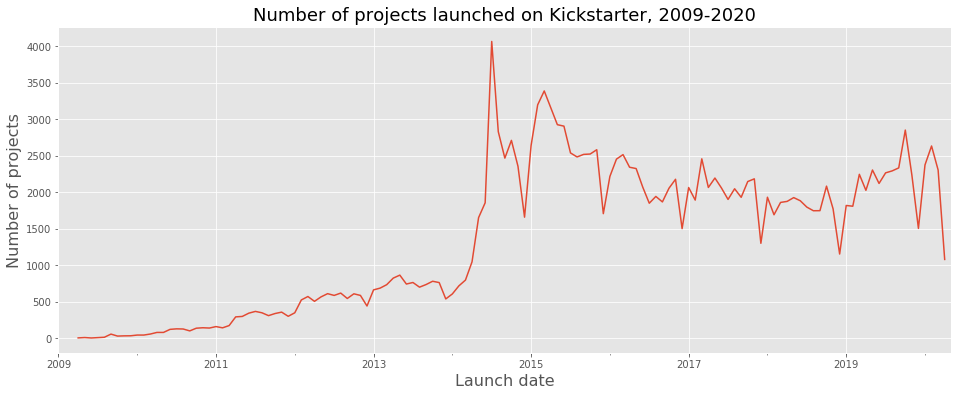

In [30]:
plt.figure(figsize=(16,6))
df.set_index('launched_at').category.resample('MS').count().plot()
plt.xlim('2009-01-01', '2020-05-01') # Limiting to whole months
plt.xlabel('Launch date', fontsize=16)
plt.ylabel('Number of projects', fontsize=16)
plt.title('Number of projects launched on Kickstarter, 2009-2020', fontsize=18)
plt.show()


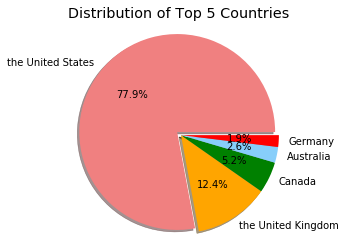

In [31]:
#df1['country_displayable_name'].value_counts()
fig, ax = plt.subplots()

pie_data = df2['country_displayable_name'].value_counts()[:5]
colors = ['lightcoral', 'orange', 'green', 'lightskyblue', 'red']
explode = (0.05,0,0,0,0)
ax.pie(pie_data.values, explode=explode, labels=pie_data.index, 
       colors=colors, autopct='%1.1f%%', shadow=True)
ax.set_title('Distribution of Top 5 Countries')

plt.axis('equal')
plt.show()

In [32]:
df2['category'][0]

'{"id":272,"name":"Mobile Games","slug":"games/mobile games","position":3,"parent_id":12,"parent_name":"Games","color":51627,"urls":{"web":{"discover":"http://www.kickstarter.com/discover/categories/games/mobile%20games"}}}'

In [33]:
df2['category'][1]

'{"id":11,"name":"Film & Video","slug":"film & video","position":7,"color":16734574,"urls":{"web":{"discover":"http://www.kickstarter.com/discover/categories/film%20&%20video"}}}'

In [34]:
# To extract category type from category column
def extract(cat):
    x = ast.literal_eval(re.search('({.+})', cat).group(0))
    if 'parent_name' not in x.keys():
        return x['slug']
    else:
        return x['parent_name'].lower()
   

In [35]:
extract(df2['category'][1])

'film & video'

In [36]:
df2['category_type'] = df2['category'].map(lambda x: extract(x))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Text(0.5, 1.0, 'Category Type Count')

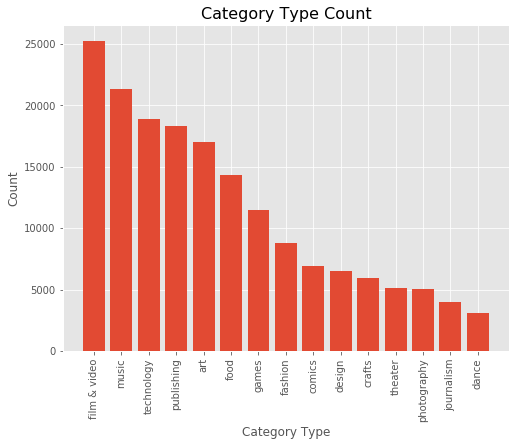

In [37]:
fig, ax = plt.subplots(figsize=(8,6))
x = df2.category_type.value_counts()
ax.bar(x.index, height=x.values)
ax.set_xticklabels(x.index, rotation=90)
ax.set_ylabel('Count')
ax.set_xlabel('Category Type')
ax.set_title('Category Type Count', size=16)

In [38]:
df2.category_type.value_counts()

film & video    25272
music           21300
technology      18877
publishing      18292
art             17054
food            14350
games           11494
fashion          8837
comics           6943
design           6553
crafts           5940
theater          5153
photography      5018
journalism       3965
dance            3077
Name: category_type, dtype: int64

In [39]:
total_pledged = df2[['category_type', 'state', 'pledged', 'backers_count']].groupby(['category_type']).sum()
total_pledged['avg'] = total_pledged['pledged']/total_pledged['backers_count']
#total_backers = df2[['category_type', 'state', 'backers_count']].groupby(['category_type']).sum()
#avg_pledged = pd.merge(total_pledged, total_backers
# avg_pledged
total_pledged

,pledged,backers_count,avg
category_type,,,
art,9.785251e+07,1014931,96.412965
comics,9.102773e+07,1371969,66.348241
crafts,3.518027e+07,245427,143.343119
dance,1.445256e+07,160491,90.052180
design,5.418078e+08,2147704,252.273020
fashion,1.537009e+08,1104736,139.129057
film & video,4.145323e+08,2839940,145.965147
food,1.136885e+08,936804,121.357812
games,8.959937e+08,5692635,157.395249


In [40]:
a = sum(df2.pledged)
b = sum(df2.backers_count)
print(a/b)

148.2837948824585


In [41]:
def word_count(blurb):
    count = 0
    if type(blurb) == str:
        count = len(blurb.split())
    else:
        count = 0
    return count

In [42]:
df2['blurb_length'] = df2['blurb'].map(lambda x: word_count(x))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [43]:
df2['country_displayable_name'].value_counts().index[:10]

Index(['the United States', 'the United Kingdom', 'Canada', 'Australia',
       'Germany', 'France', 'Mexico', 'Italy', 'Spain', 'the Netherlands'],
      dtype='object')

In [44]:
df2['country_displayable_name'].value_counts()

the United States     120688
the United Kingdom     19134
Canada                  8007
Australia               4034
Germany                 3001
France                  2375
Mexico                  2277
Italy                   2079
Spain                   1807
the Netherlands         1480
Sweden                  1204
Hong Kong               1014
New Zealand              787
Denmark                  747
Singapore                618
Switzerland              583
Ireland                  549
Belgium                  480
Austria                  415
Norway                   401
Japan                    392
Luxembourg                53
Name: country_displayable_name, dtype: int64

In [99]:
def country_cat(x):
    country_list = ['the United States', 'the United Kingdom ', 'Canada', 'Australia',
                   'Germany', 'France', 'Mexico', 'Italy', 'Spain', 'the Netherlands']
    for country in x:
        if country in country_list:
            return country
        else:
            return 'other'

In [100]:
df2['country_name'] = df['country_displayable_name'].map(lambda x: country_cat([x]))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [106]:
df2.shape

(172125, 18)

## One Hot Encode!



In [143]:
# one hot encoding!!
df2_ohe = pd.get_dummies(df2[['category_type', 'country_name', 'staff_pick']])

In [144]:
df2.columns

Index(['backers_count', 'blurb', 'category', 'country_displayable_name',
       'deadline', 'goal', 'launched_at', 'name', 'pledged', 'slug',
       'staff_pick', 'state', 'launched_year', 'launched_month',
       'campaign_length', 'category_type', 'blurb_length', 'country_name'],
      dtype='object')

In [145]:
data = pd.merge(df2, df2_ohe, left_index=True, right_index=True)
data.shape

(172125, 44)

In [153]:
good_data = data[data['state'].isin(['successful', 'failed'])]
live = data[data['state'].isin(['live'])]
print(good_data.shape)
print(live.shape)

(169591, 44)
(2534, 44)


In [156]:
good_data['state'] = good_data['state'].replace(to_replace=['successful', 'failed'], value=[1,0])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [159]:
model_data = good_data.copy()

In [160]:
model_data.columns

Index(['backers_count', 'blurb', 'category', 'country_displayable_name',
       'deadline', 'goal', 'launched_at', 'name', 'pledged', 'slug',
       'staff_pick_x', 'state', 'launched_year', 'launched_month',
       'campaign_length', 'category_type', 'blurb_length', 'country_name',
       'staff_pick_y', 'category_type_art', 'category_type_comics',
       'category_type_crafts', 'category_type_dance', 'category_type_design',
       'category_type_fashion', 'category_type_film & video',
       'category_type_food', 'category_type_games', 'category_type_journalism',
       'category_type_music', 'category_type_photography',
       'category_type_publishing', 'category_type_technology',
       'category_type_theater', 'country_name_Australia',
       'country_name_Canada', 'country_name_France', 'country_name_Germany',
       'country_name_Italy', 'country_name_Mexico', 'country_name_Spain',
       'country_name_other', 'country_name_the Netherlands',
       'country_name_the United Stat

In [167]:
X = model_data.drop(['backers_count','blurb', 'category', 'country_displayable_name', 'deadline', 
                     'launched_at', 'name', 'pledged', 'slug', 'state', 'category_type', 'country_name'],
                   axis=1)
y = model_data['state']


## Modeling

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [171]:
def get_scores(classifier, X_train, X_test, y_train, y_test, **kwargs):
    model = classifier(**kwargs)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    return model.score(X_test, y_test), \
           precision_score(y_test, y_predict), \
           recall_score(y_test, y_predict)

print("Model, Accuracy, Precision, Recall")
print("    Random Forest:", get_scores(RandomForestClassifier, X_train, X_test, y_train, y_test, n_estimators=25, max_features=5))
print("    Logistic Regression:", get_scores(LogisticRegression, X_train, X_test, y_train, y_test))
print("    Gradient Boost:", get_scores(GradientBoostingClassifier, X_train, X_test, y_train, y_test))


Model, Accuracy, Precision, Recall
    Random Forest: (0.7255530921269872, 0.7526860638381303, 0.7827026586201272)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


    Logistic Regression: (0.6224350205198358, 0.6098498529487643, 0.9639129016473659)
    Gradient Boost: (0.7360960422661447, 0.7460967777654745, 0.8242537922035557)


In [ ]:
print("17. Use the included `plot_roc` function to visualize the roc curve of each model")
plot_roc(X, y, RandomForestClassifier, 'Random_Forest', n_estimators=25, max_features=5)
plot_roc(X, y, LogisticRegression, 'Logistic_Regression')
plot_roc(X, y, DecisionTreeClassifier, 'Decision_Tree')
